In [1]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file

c:\Users\cheng\Workspace\robinhood_classifer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ML Pipeline Flow

In [2]:
# 1. EDA Analysis
# 2. Feature Engineering
# 3. Train-Test Split
# 4. Feature Scaling: {normalization/standardization, dimension reduction techniques, handling imbalance datasets/sampling}
# 5. Model Training -> Tuning -> Evaluating
# 6. Model Prediction
# 7. Model Deployment

In [3]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df


,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn_flag
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0
...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,0
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,1
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,0
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,0


### Step 1: Data Preprocessing

In [4]:
# Label encoding for categorical variables
label_enc = LabelEncoder()
df['risk_tolerance'] = label_enc.fit_transform(df['risk_tolerance'])
df['investment_experience'] = label_enc.fit_transform(df['investment_experience'])
df['liquidity_needs'] = label_enc.fit_transform(df['liquidity_needs'])
df['platform'] = label_enc.fit_transform(df['platform'])
df['time_horizon'] = label_enc.fit_transform(df['time_horizon'])

# Scaling the numerical features
scaler = StandardScaler()
df[['time_spent', 'first_deposit_amount']] = scaler.fit_transform(df[['time_spent', 'first_deposit_amount']])

# Feature Engineering
df['deposit_per_time'] = df['first_deposit_amount'] / df['time_spent']
df['is_high_risk'] = (df['risk_tolerance'] == 'high_risk_tolerance').astype(int)

### Step 2: Handling Class Imbalance

In [7]:
# THIS GIVES AN ERROR: Split the dataset into features and target
# X = df.drop(columns=['user_id', 'churn_flag'])
# y = df['churn_flag']

# # Handle imbalance using SMOTE
# smote = SMOTE()
# X_resampled, y_resampled = smote.fit_resample(X, y)
'''ArithmeticError
The error occurs because the SMOTE() function expects all the feature columns in X to be numeric, but it appears that one or more columns (like 'stock') in your X dataset are categorical (strings). SMOTE (Synthetic Minority Over-sampling Technique) can only handle numeric data, so you need to convert categorical columns into numeric format before applying SMOTE.

To fix this, you can perform the following steps:

Convert Categorical Variables: Use one-hot encoding or label encoding to convert categorical variables into numerical ones.

Apply SMOTE after ensuring that all feature columns are numeric.

Here’s how you can modify the code:

Option 1: Use One-Hot Encoding for Categorical Variables
This method will convert categorical columns into multiple binary (0/1) columns.'''
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Split the dataset into features and target
X = df.drop(columns=['user_id', 'churn_flag'])

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

y = df['churn_flag']

# Handle imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Now you can proceed with model training using X_resampled and y_resampled


'''Option2: Use Label Encoding (Only if Categorical Variables Have Ordinal Meaning
If your categorical variables have an inherent order, you can use label encoding. This assigns a unique integer to each category.

However, one-hot encoding is generally preferred unless you have a valid reason to assume an ordinal relationship.

By applying one of these strategies, the error related to string values should be resolved, and you can use SMOTE to handle class imbalance.
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Split the dataset into features and target
X = df.drop(columns=['user_id', 'churn_flag'])
y = df['churn_flag']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

# Handle imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Now you can proceed with model training using X_resampled and y_resampled

'''


"Option2: Use Label Encoding (Only if Categorical Variables Have Ordinal Meaning\nIf your categorical variables have an inherent order, you can use label encoding. This assigns a unique integer to each category.\n\nHowever, one-hot encoding is generally preferred unless you have a valid reason to assume an ordinal relationship.\n\nBy applying one of these strategies, the error related to string values should be resolved, and you can use SMOTE to handle class imbalance.\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.model_selection import train_test_split\nfrom imblearn.over_sampling import SMOTE\nimport pandas as pd\n\n# Split the dataset into features and target\nX = df.drop(columns=['user_id', 'churn_flag'])\ny = df['churn_flag']\n\n# Identify categorical columns\ncategorical_cols = X.select_dtypes(include=['object']).columns\n\n# Initialize LabelEncoder\nlabel_encoder = LabelEncoder()\n\n# Apply label encoding to each categorical column\nfor col in categorical_cols:\n

### Step 3: Train-Test Split

In [8]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


### Step 4: Model Training and Hyperparameter Tuning using Optuna

In [9]:
def objective(trial):
    model = xgb.XGBClassifier(
        max_depth=trial.suggest_int('max_depth', 3, 10),
        learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        n_estimators=trial.suggest_int('n_estimators', 50, 300)
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

# Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


[I 2024-10-03 19:07:40,903] A new study created in memory with name: no-name-0790d66c-d874-4dd2-b007-75ce8ecc0ac2
C:\Users\cheng\AppData\Local\Temp\ipykernel_17792\4074505116.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2024-10-03 19:07:41,205] Trial 0 finished with value: 0.8586492107639117 and parameters: {'max_depth': 6, 'learning_rate': 0.025827374192019536, 'n_estimators': 102}. Best is trial 0 with value: 0.8586492107639117.
C:\Users\cheng\AppData\Local\Temp\ipykernel_17792\4074505116.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rat

### Step 5: Evaluation

In [10]:
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(conf_matrix)
print(class_report)


Accuracy: 0.9220860823122841
ROC AUC: 0.9221176867400597
[[1493  129]
 [ 119 1442]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1622
           1       0.92      0.92      0.92      1561

    accuracy                           0.92      3183
   macro avg       0.92      0.92      0.92      3183
weighted avg       0.92      0.92      0.92      3183



### Step 6: Model Explainability with SHAP

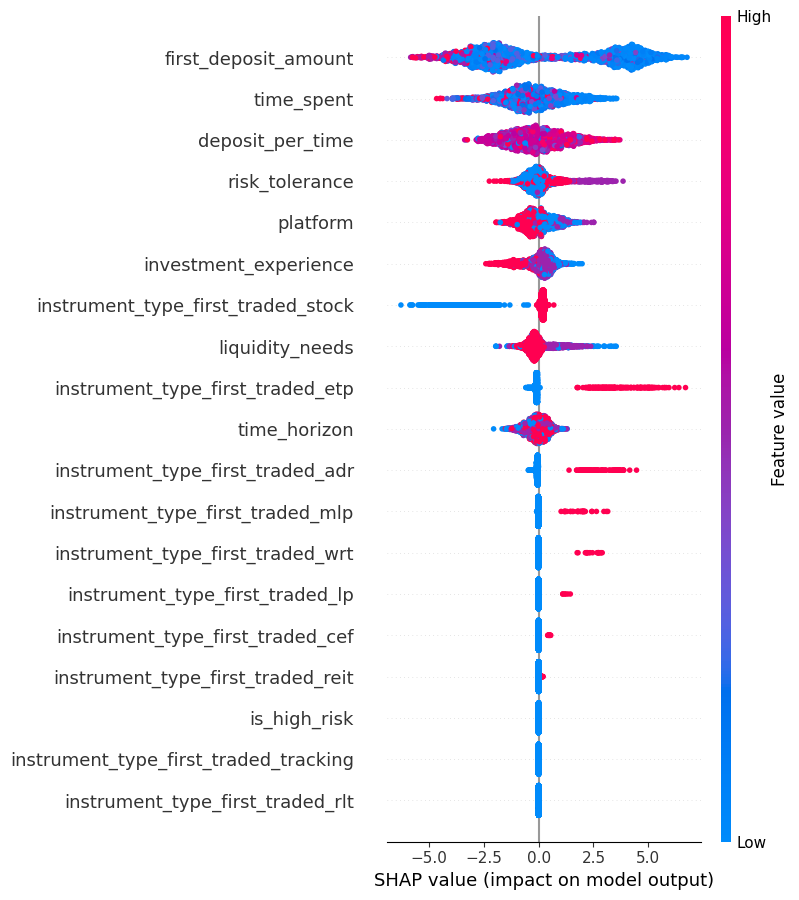

In [11]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


## EDA

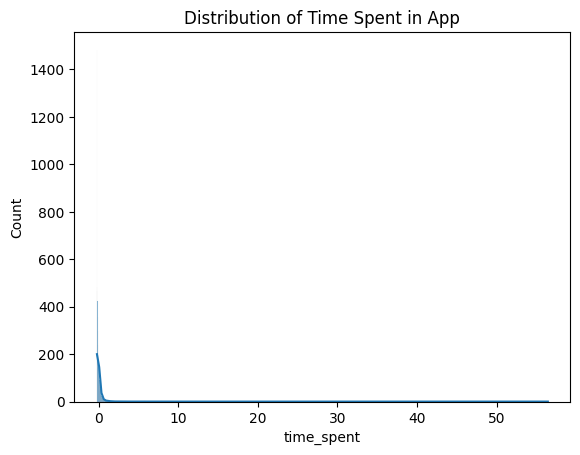

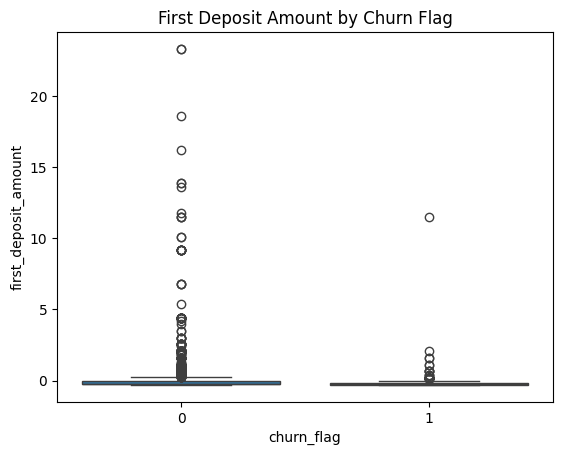

In [12]:
# Distribution of Numerical Features:
sns.histplot(df['time_spent'], kde=True)
plt.title('Distribution of Time Spent in App')
plt.show()

sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df)
plt.title('First Deposit Amount by Churn Flag')
plt.show()


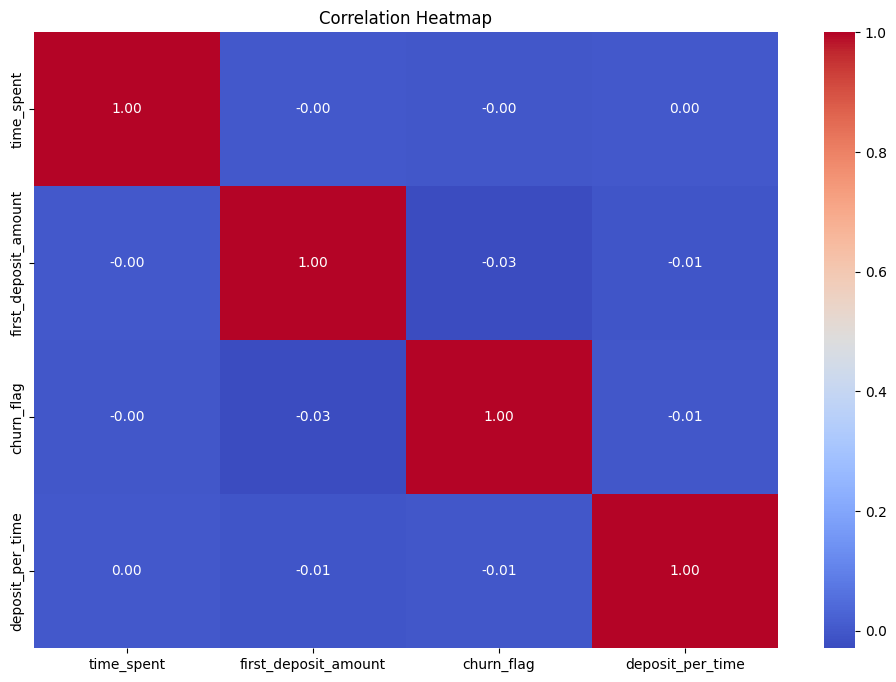

In [14]:
# plt.figure(figsize=(12,8))
# sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
# plt.title('Correlation Heatmap')
# plt.show()

# Select only the numerical columns from the DataFrame
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create the heatmap using the correlation matrix of the numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

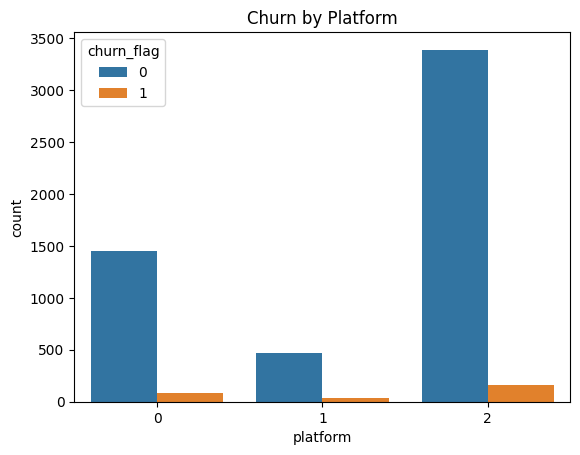

In [15]:
# categorical features
sns.countplot(x='platform', hue='churn_flag', data=df)
plt.title('Churn by Platform')
plt.show()
